In [17]:
# importing required libraries
import pandas as pd  # pandas library
import numpy as np   # numphy library
import random        # random generation of number
import os            # to see the path of the current file

In [18]:
#Reading Dataset
# Use lowercase 'data' to match your professional structure
#df = pd.read_csv('../Data/raw/bank-full.csv', sep=',', encoding='latin1')
df = pd.read_excel('../Data/raw/bank-full.xlsx')  # reading the full dataset of bank
print(df.head())
print(df.shape)
# Reading the subset of full bank dataset
df_sub = pd.read_csv('../Data/raw/bank.csv',sep=';')  # reading the subset(Sampling) dataset of bank
print(df_sub.head())
print(df_sub.shape)


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
(45211, 17)
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  marri

# Initial EDA : Univariate 

1. Identify the "Problem" Areas
Before cleaning, you use Univariate EDA to find the things that need fixing.

Numerical Outliers: You use boxplots to see if the €102k balance is an error or just a wealthy customer.

Categorical "Unknowns": You use count plots to see that poutcome is mostly "unknown." This justifies why you might drop it later or treat "unknown" as a category.

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel

plt.xlabel = xlabel
plt.ylabel = ylabel
 

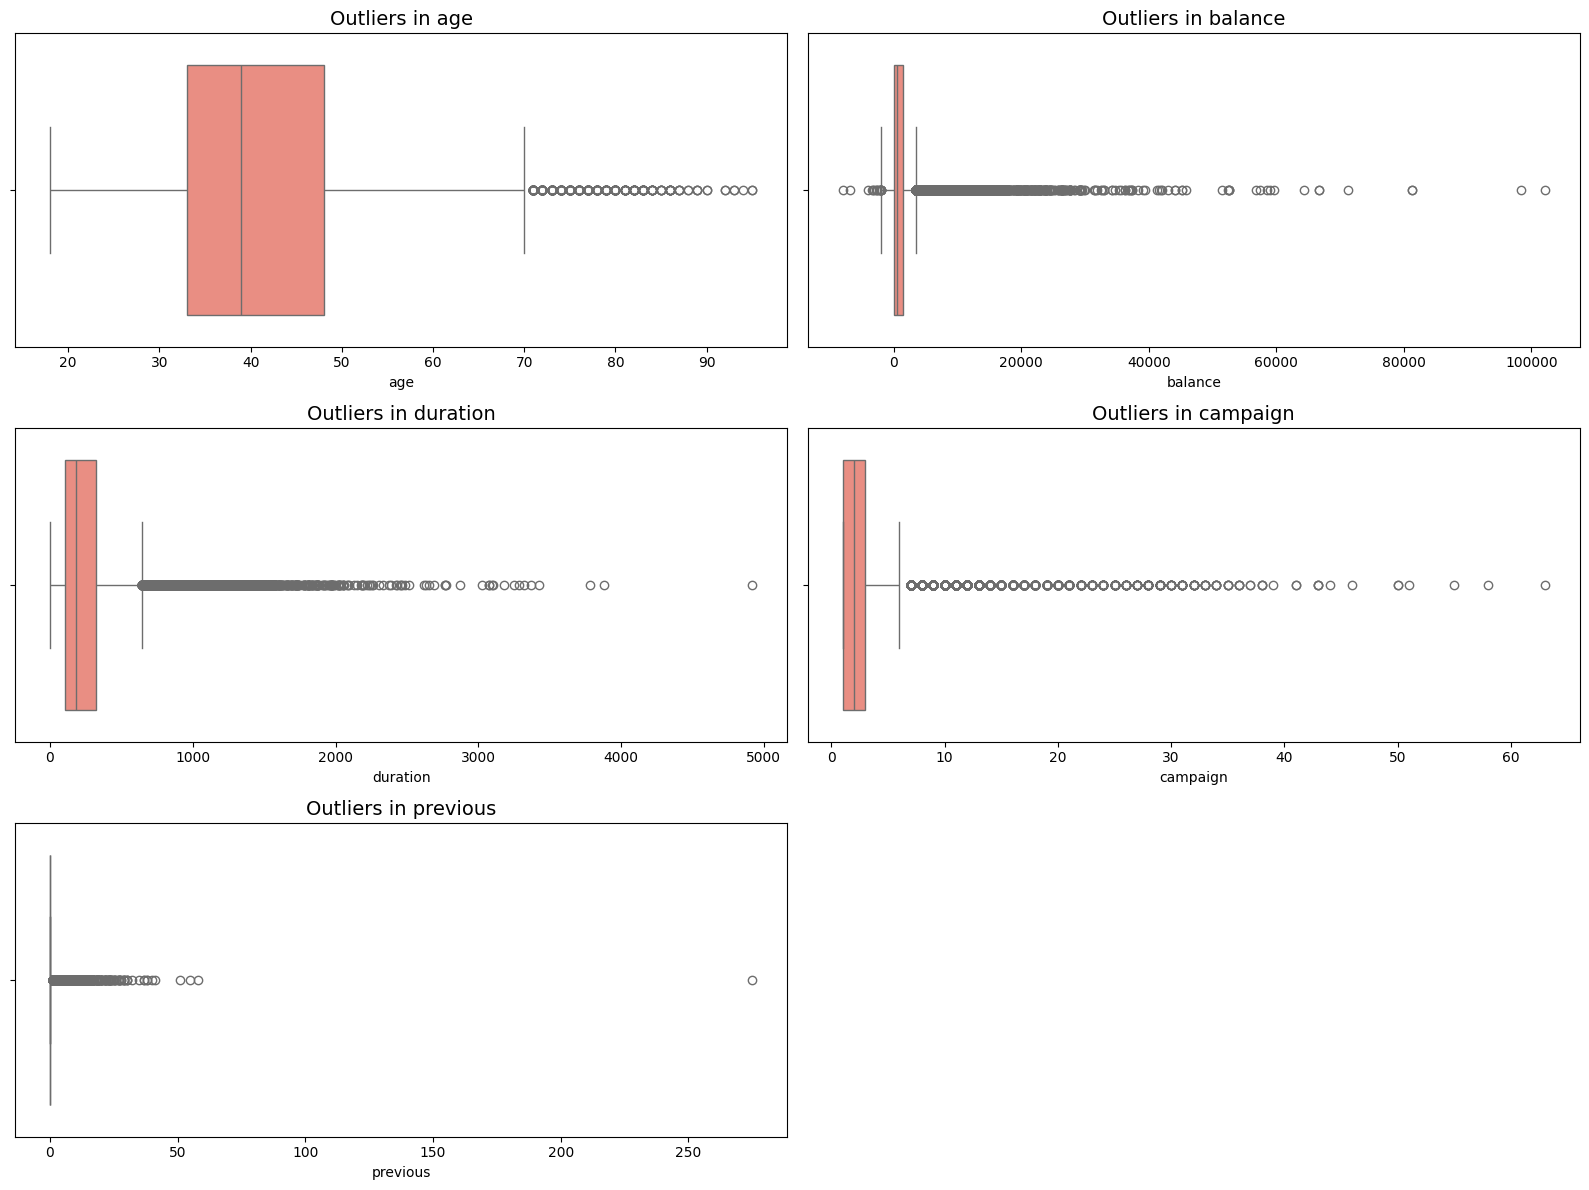

In [21]:
# List of numerical columns that likely have outliers
outlier_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

plt.figure(figsize=(16, 12))

for i, col in enumerate(outlier_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Outliers in {col}', fontsize=14)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Using Boxplots is the industrial standard for identifying outliers because they visually represent the "Interquartile Range" (IQR). In banking data, outliers in balance or duration aren't always errors—they are often "High Net Worth" individuals or "Highly Engaged" prospects.

When we get to Cleaning, will not delete the outliers otherwise may lose too much data. Instead, will cap them at the 99th percentile. This keeps the "High Value" signal without letting the €102,127 balance break our model.

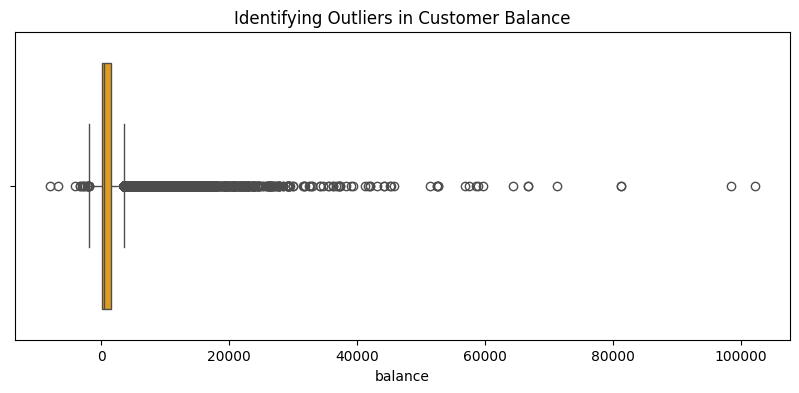

In [22]:
# 1. Visualize Balance Outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['balance'], color='orange')
plt.title('Identifying Outliers in Customer Balance')
plt.show()



**Numerical Univariate Analysis**  (Use Histograms & Boxplots)

For these columns, we are looking for skewness (is the data centered?) and outliers (like your €102k balance).
Key Columns: age, balance, duration, campaign, pdays.

Visualizations to use:

Histograms: To see the distribution.

Boxplots: Specifically to identify those outliers you mentioned in your describe() output.

- age: To see the age range of the bank's customers.
- balance: To identify wealth distribution and extreme outliers (like the €102k you found).
- day: To see if calls are concentrated at the start, middle, or end of the month.
- duration: Crucial variable. High duration usually correlates with success.
- campaign: To see how many times a customer is usually contacted in one campaign.
- pdays: Note: $-1$ means "never contacted before." w'll see a huge spike at $-1$.
- previous: To see the history of previous contacts.

Check the "natural shape" of your continuous data.

Age: Is the bank targeting retirees or young professionals?

Balance: Is most of the data near zero? (In banking, this usually shows a "long tail" distribution).

Duration: Check for 0-second calls. These are "errors" (missed calls) that you'll want to clean later.

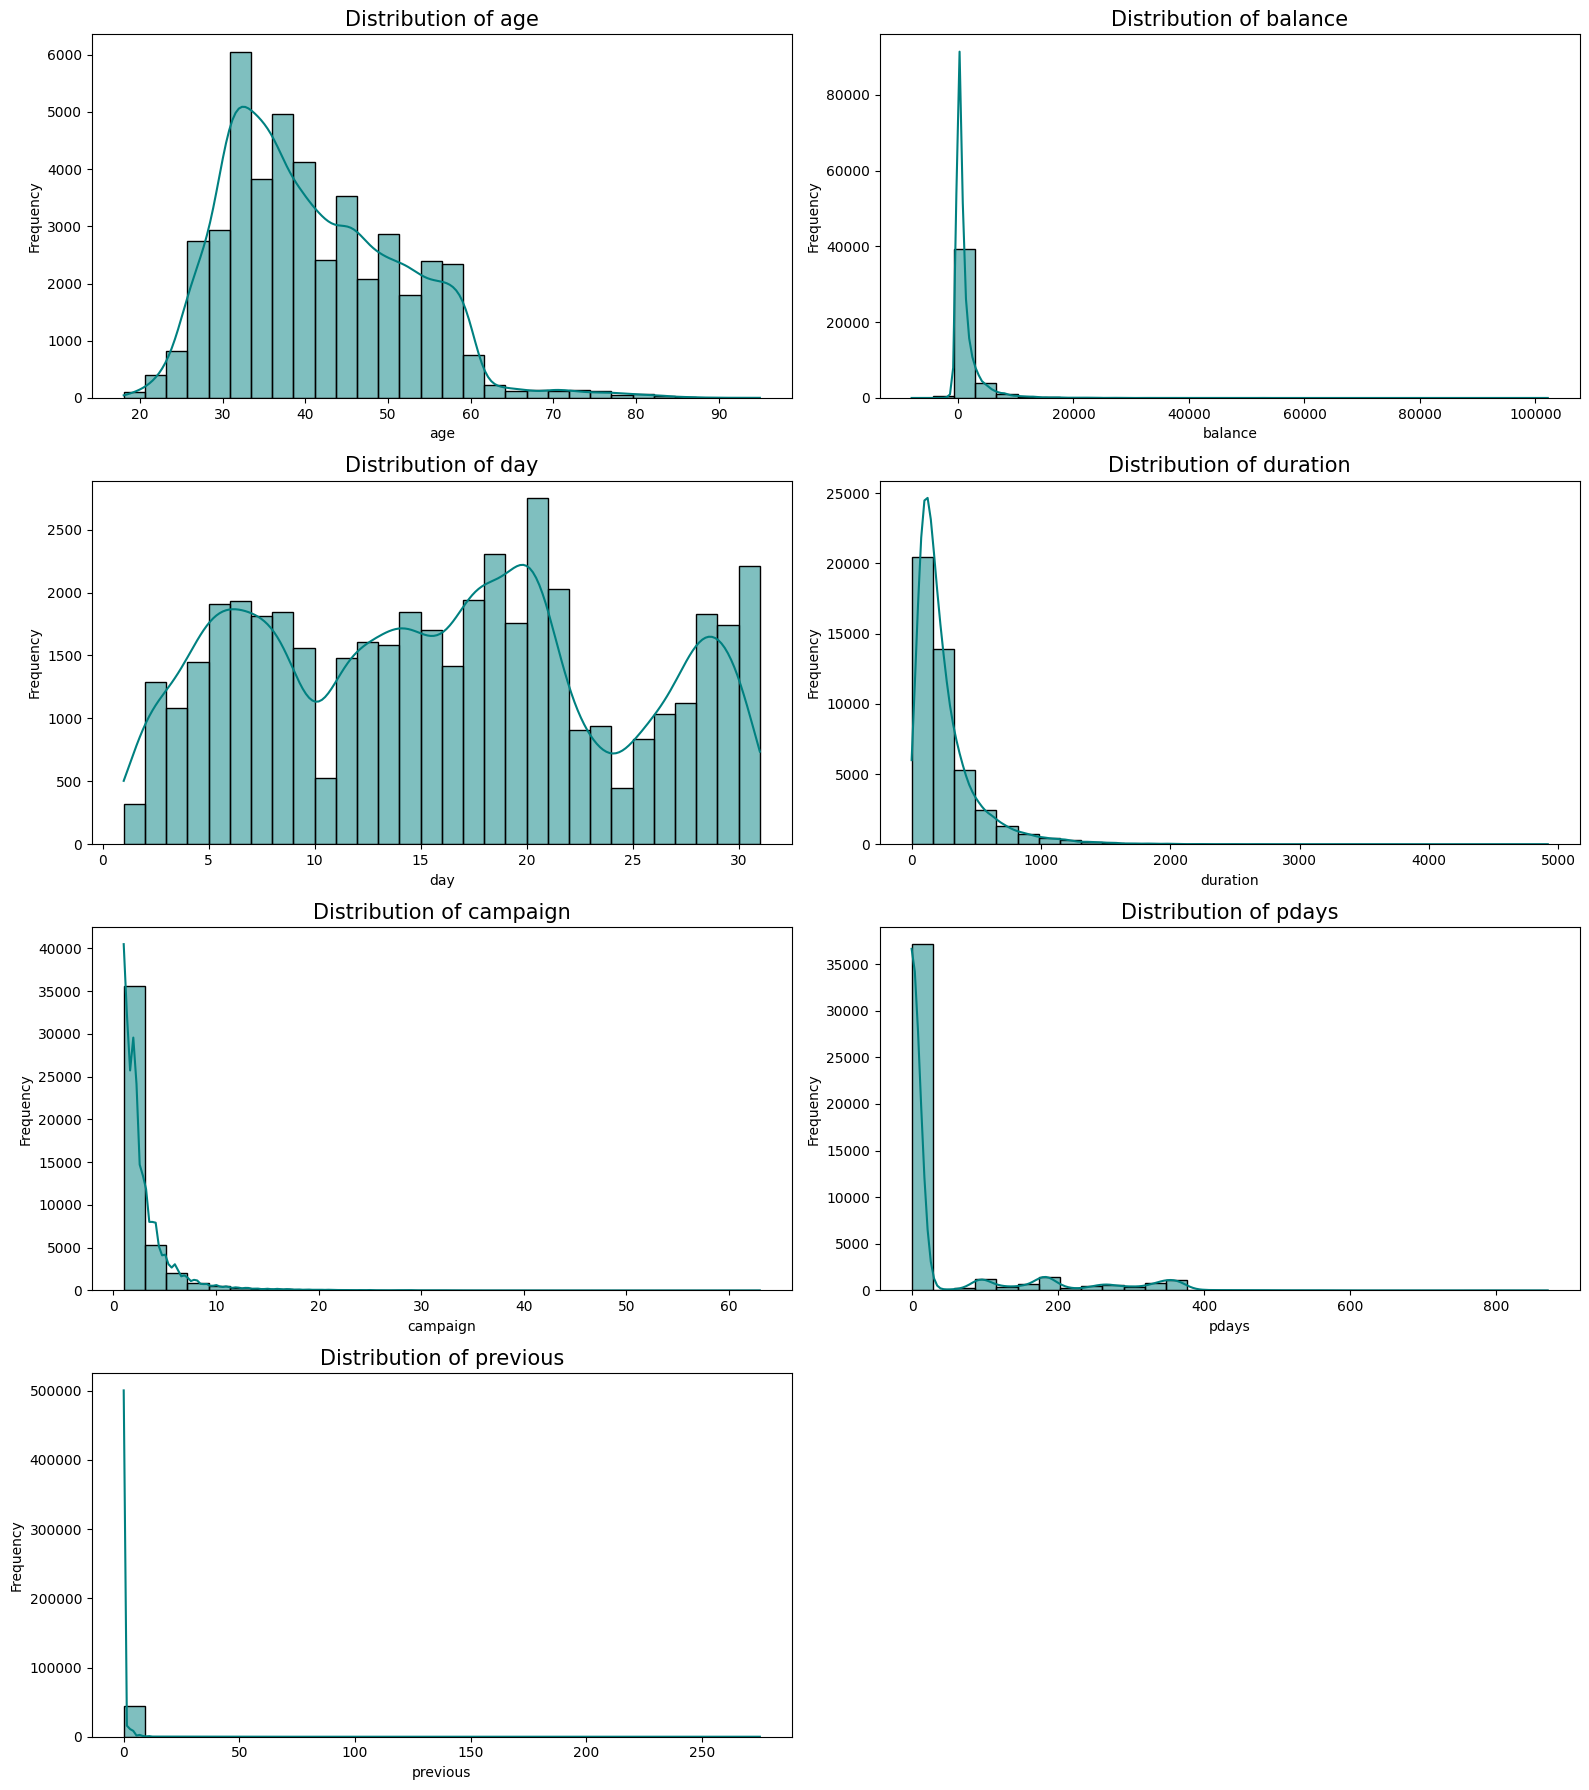

In [23]:
# EDA - Part A: Univariate Analysis (Numerical Variables)

# List of numerical columns
num_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create subplots - 4 rows, 2 columns to fit all 7 variables
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
axes = axes.flatten() # Flatten to 1D array for easy indexing

for i, col in enumerate(num_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove the 8th empty subplot (since we only have 7 numerical columns)
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

What to look for in these plots (Before Cleaning):
age: Usually fairly normal but slightly right-skewed. that shows most customers are between 30 and 50.

balance: This will likely look like a single vertical line at the left because of those extreme outliers (€100k+). This is visual "proof" that says, need to cap or scale this data later.

duration: Heavily right-skewed. Most calls are short, but a few are very long. This is a very important predictor.

campaign: Most values are at the very low end (1-3 contacts). The "long tail" shows people contacted 60+ times—often considered outliers.

pdays: A massive spike at -1. This represents all the customers who were never contacted before. In banking, this is a distinct "New Lead" segment.

previous: Like campaign, mostly zeros. Any high numbers here are "Frequent Contacts."

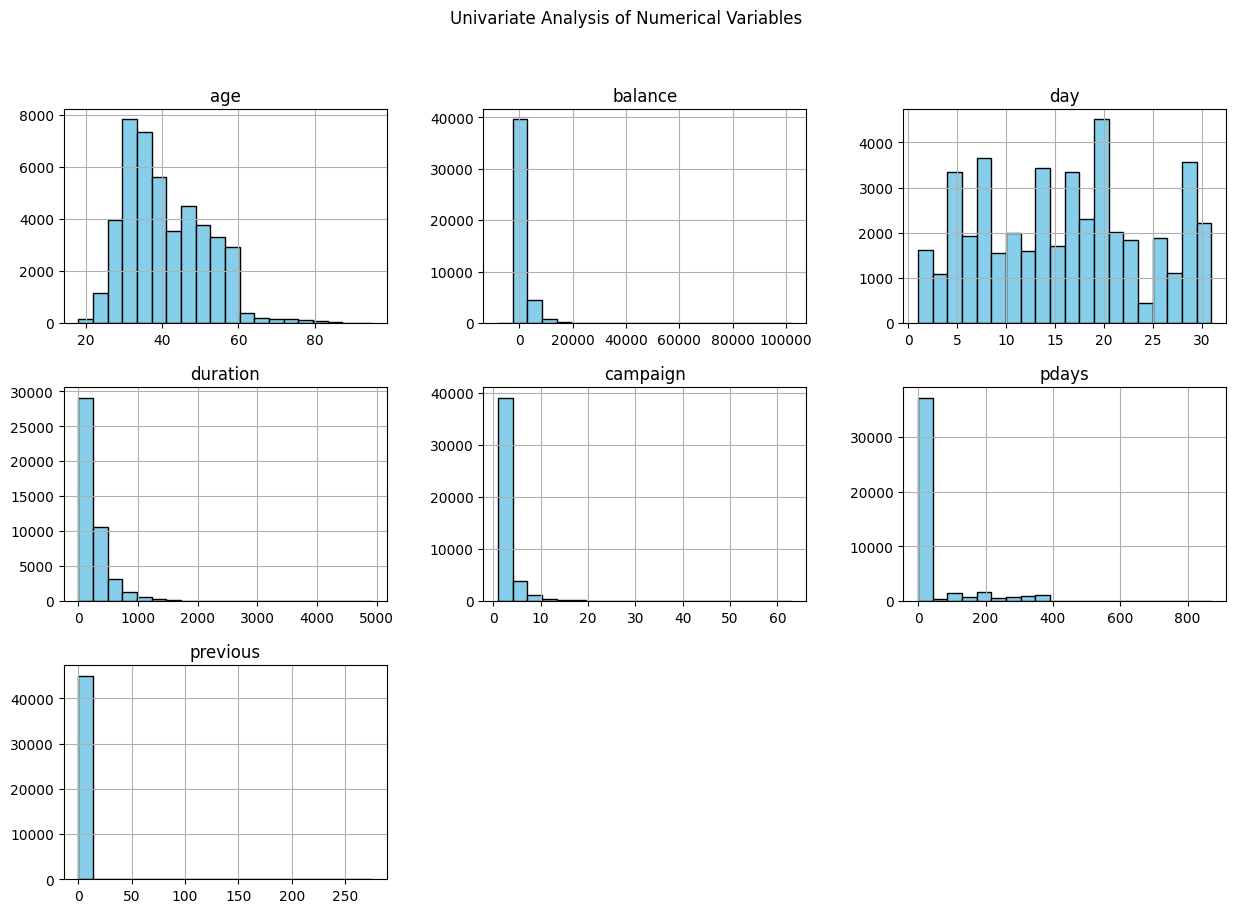

In [24]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_cols].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Univariate Analysis of Numerical Variables')
plt.show()

**Categorical Univariate Analysis**

For these, we are looking for frequency and imbalance. Want to see if one category dominates the others.

Key Columns: job, marital, education, default, housing, loan, contact, month, poutcome.

Visualizations to use:

Count Plots (Bar Charts): To see the frequency of each category.

What to look for: Does blue-collar make up 50% of the jobs? Is poutcome mostly "unknown"? (Which you already found is 81.75%!).

- job: Which professions does the bank target most?
- marital: Married, single, or divorced distribution.
- education: Educational background of the leads.
- default: Do many customers have credit in default? (Usually, most are "no").
- housing: How many have housing loans?
- loan: How many have personal loans?
- contact: How the bank reached out (Cellular vs. Telephone).
- month: Which months are the busiest for the bank?
- poutcome: Success/Failure of previous campaigns (Remember, this had 81% "unknown")

Look for "Sparse Classes" (categories with very few people).

Job: If "Student" or "Housemaid" only has a few rows, your model might struggle to learn about them.

Default: Does anyone actually have a credit default? If 99% are "No," this column might not be useful for the model.

Here is the code to generate subplots for all categorical variables. In the banking industry, it is called "Class Distribution Analysis"—it's how one can spot the "Unknowns" and the class imbalance found in statistics.

C:\Users\jalpa\AppData\Local\Temp\ipykernel_39100\1636977189.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], order=order, palette='viridis')
C:\Users\jalpa\AppData\Local\Temp\ipykernel_39100\1636977189.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], order=order, palette='viridis')
C:\Users\jalpa\AppData\Local\Temp\ipykernel_39100\1636977189.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], order=order, palette='viridis')
C:\Users\jalpa\AppD

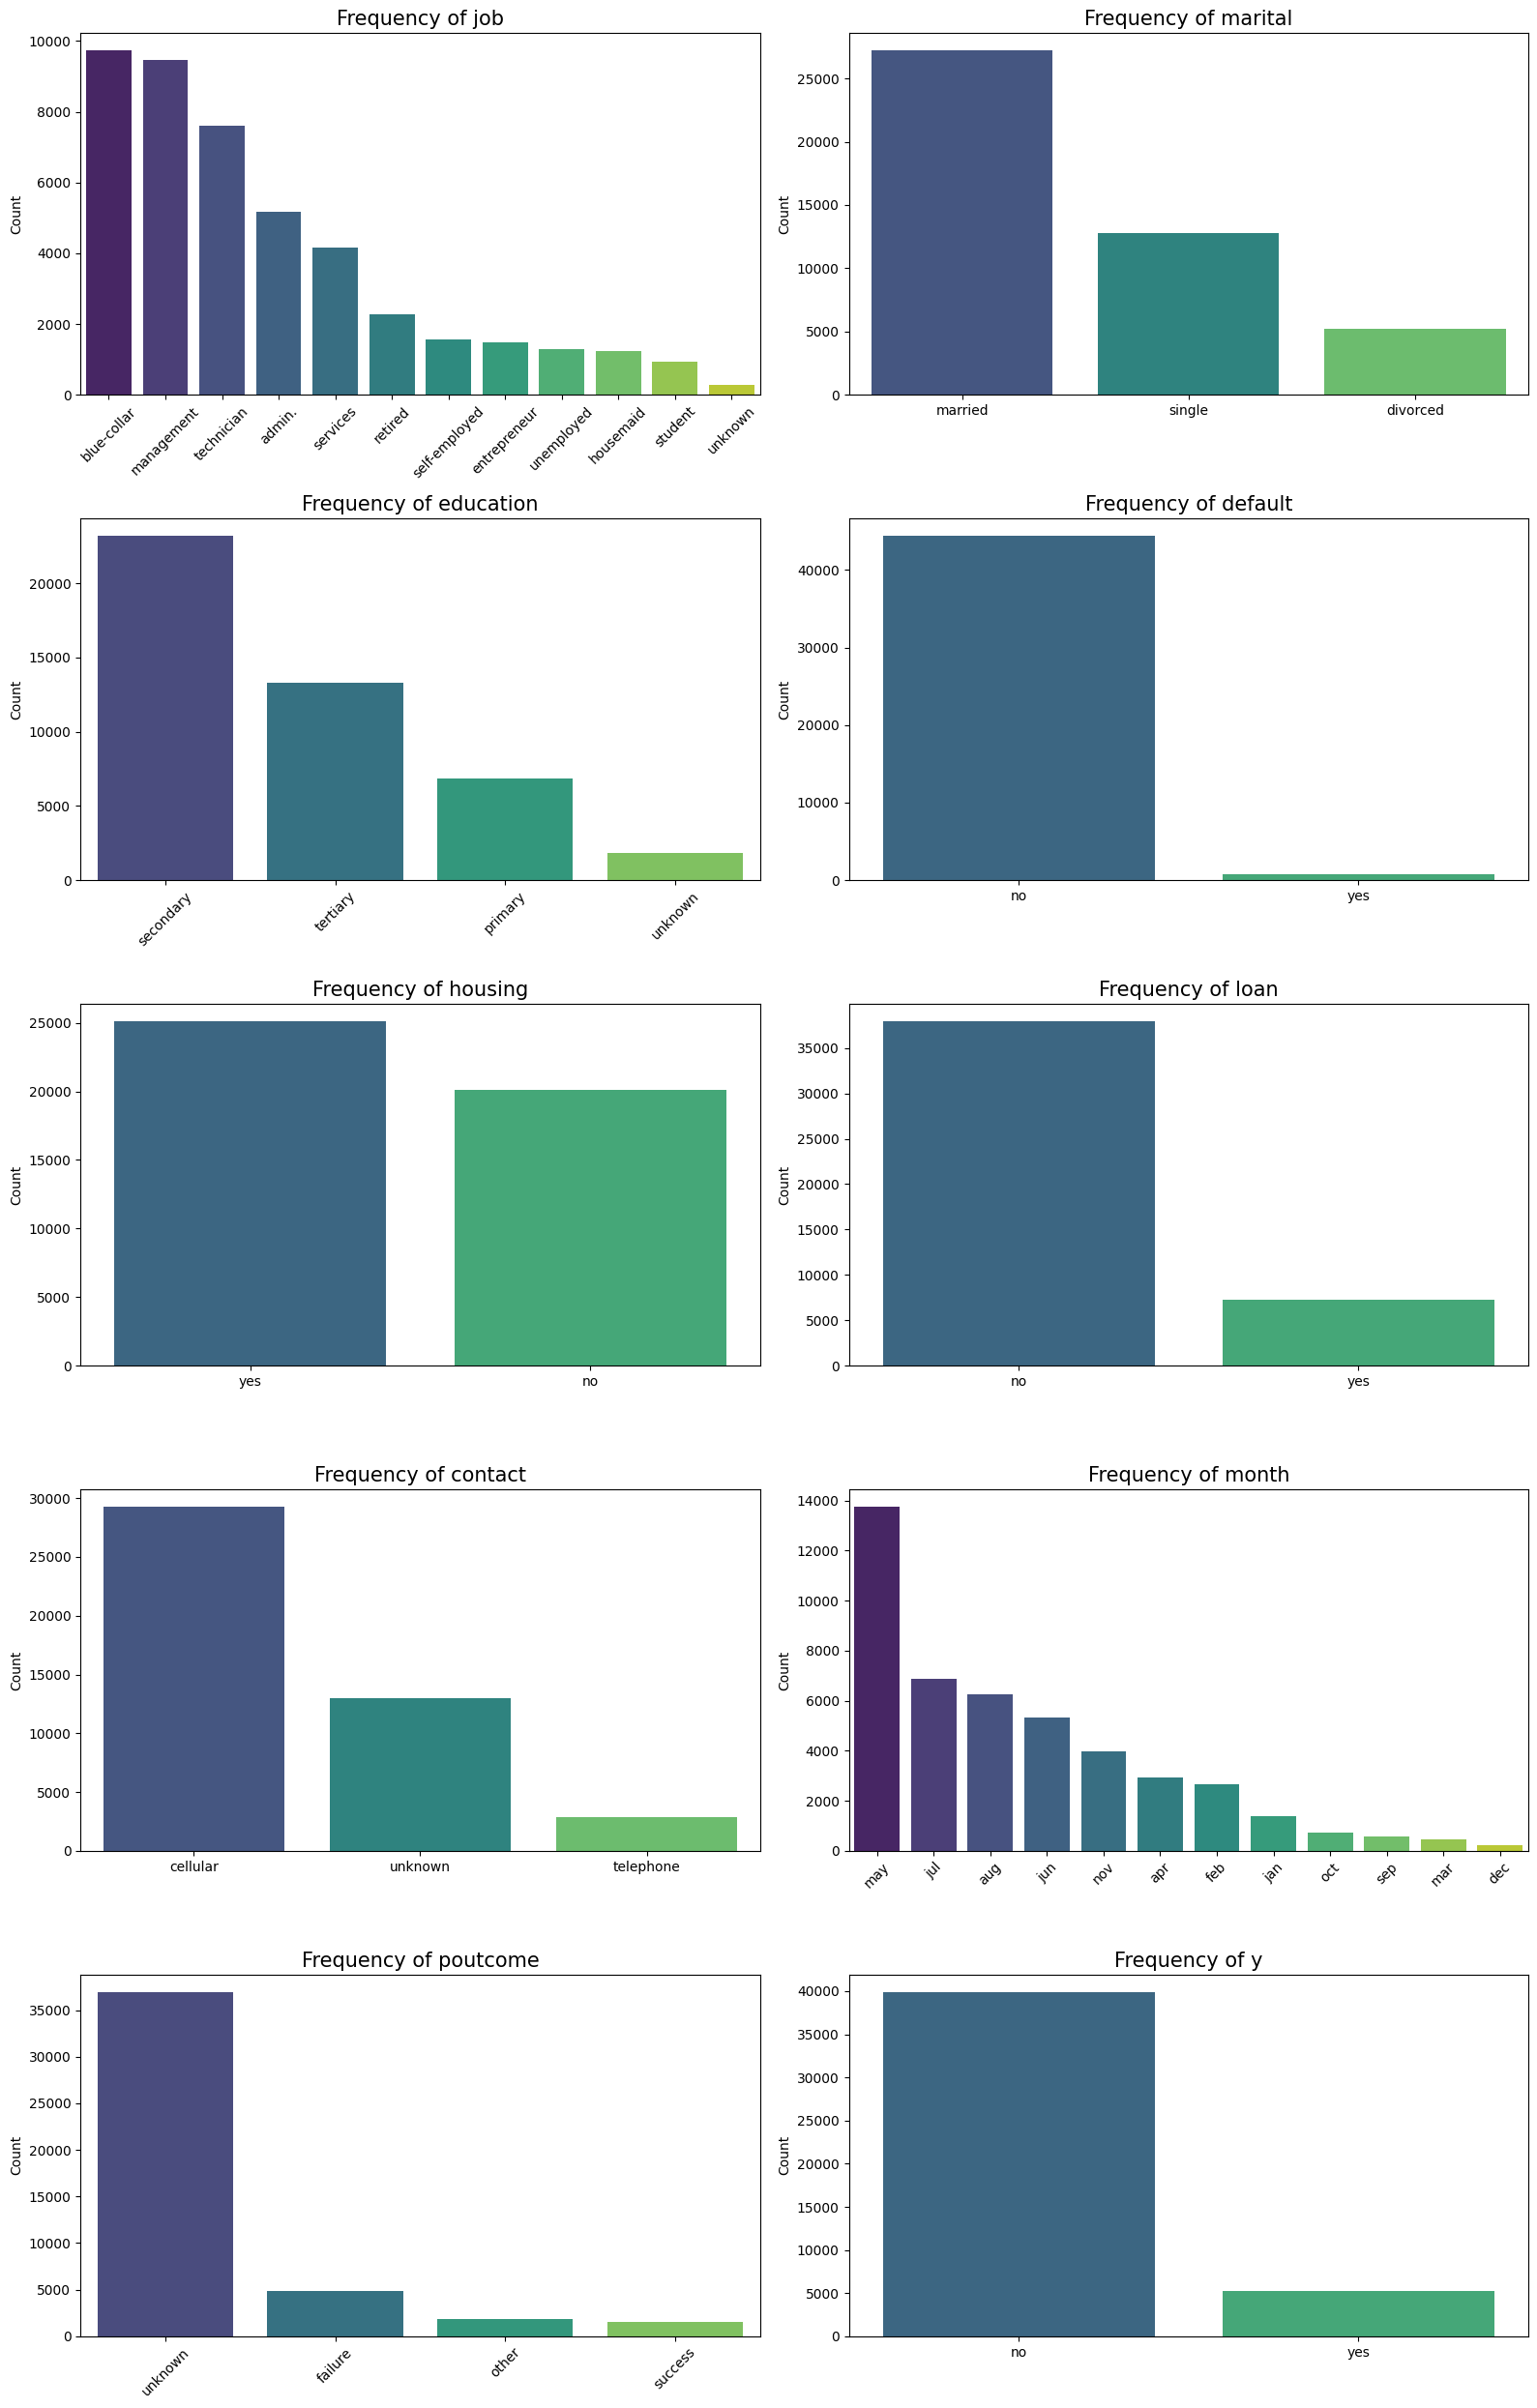

In [25]:
# EDA - Part A: Univariate Analysis (Categorical Variables)

# List of categorical columns from your info() output
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# Create subplots - 5 rows, 2 columns for the 10 categorical variables
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25))
axes = axes.flatten()

for i, col in enumerate(cat_columns):
    # Sort bars by frequency for better readability
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, ax=axes[i], order=order, palette='viridis')
    
    axes[i].set_title(f'Frequency of {col}', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    
    # Rotate x-labels for columns with many categories (like job and month)
    if df[col].nunique() > 3:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Crucial Banking Insights to Spot:
Class Imbalance (The y chart):  we can see "no" towers over "yes." In a banking marketing context, this is normal but dangerous for a model. It means the model will naturally try to ignore the "yes" customers.

The "Unknown" Dominance: Look at poutcome. "unknown" is the massive majority. This visually confirms calculation that 81% of previous outcomes are missing.

Dominant Segments: Notice how blue-collar and management jobs, and married status, make up the bulk of our leads.

Credit Health: The default chart will likely be almost entirely "no." This tells that "default" might not have enough variance to be a strong predictor for model later.

Why we do this before cleaning:
By plotting these now, we can see the "unknown" bars. When you run your cleaning code later and re-plot these, those "unknown" bars will disappear (merged into the mode), and you can visually verify that your cleaning worked.

**The Target Variable (The Most Important One)**

Even though y is categorical, we analyze it alone first to check for Class Imbalance.

Column: y (Term Deposit Subscription).

Insight: In this dataset, "no" usually happens about 88% of the time. This tells you that later on, you might need special modeling techniques (like SMOTE or class weights) because the "yes" cases are rare. 

y: This is the most important univariate analysis. We check for Class Imbalance. If 90% are "no" and 10% are "yes," we need to note this as it affects our future model's accuracy.

Check the distribution of y.

Class Imbalance: In this dataset, you will likely see that ~88% said "No" and ~12% said "Yes."

The Cleaning Impact: By looking at this now, you'll know that if you delete too many "unknown" rows later, you might accidentally delete all your "Yes" cases!

C:\Users\jalpa\AppData\Local\Temp\ipykernel_39100\3758218147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=df, palette='viridis')


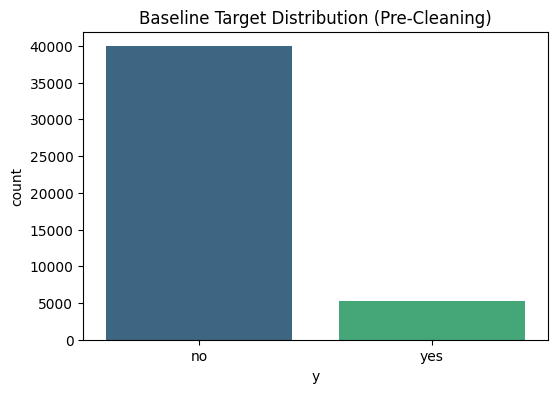

In [26]:
# 1. Visualize the Target (Check for Imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df, palette='viridis')
plt.title('Baseline Target Distribution (Pre-Cleaning)')
plt.show()

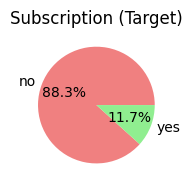

In [27]:
plt.subplot(1, 3, 3)
df['y'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Subscription (Target)')
plt.show()

   # Data Cleaning:

The initial step involves cleaning and preparing the raw data to remove inconsistencies, handle missing values, and make the dataset ready for analysis. 

1. Check for Missing Values: Ensure there are no null values.
2. Handle Duplicates: Identify and remove any duplicate rows.
3. Consistant Data for Analysis: Ensure consistent formats for categorical data (e.g., month values).
4. Impute: Replace unknown in job or education with the mode.
5. Handle Outliers: Cap the extreme balance values (Capping/Winsorization).
6. Standardize Strings: Strip spaces and lowercase all categories .


In [ ]:
# 1. Check for missing values in both datasets
missing = df.isnull().sum()
missing_sub = df_sub.isnull().sum()

# 2. Identify duplicate rows: Check for duplicates in both datasets
duplicates = df.duplicated().sum()
duplicates_sub = df_sub.duplicated().sum()

missing, missing_sub, duplicates, duplicates_sub


(age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64,
 age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64,
 np.int64(0),
 np.int64(0))

String Standardizing First: One should lowercase and strip before calculate the Mode. If data have "Management" and "management", they are seen as different; standardizing them first gives a more accurate Mode for imputation.

In [ ]:
# 3 & 6. Standardize Strings (Lowercase & Strip)
# This ensures 'Management' and 'management ' are treated as the same category
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].str.lower().str.strip()

print("Cleaning  Data is standardized and missing and duplicats are identified.")

C:\Users\jalpa\AppData\Local\Temp\ipykernel_39100\4293830555.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=['object']).columns


Looks like there are no missing values in our data. However, if we look at the categorical data there are 'unknown' values which we can consider as 'missing' data.

Also, there are no duplicates rows in our data. 

The data are consistant and standardize for computing.

We will follow below steps to handle 'unknown' values from "job', 'education','contact' and 'poutcome' columns.
First, calculate the percentage of "unknown" values in each column to understand the extent of the issue.



In [ ]:
# 4. Impute: Replace unknown in job or education with the mode.
# selected only categorical columns

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# count unknown values in each column

unknown_counts = df[categorical_columns].apply(lambda col: (col == "unknown").sum())

print(unknown_counts) # the output will give unknown counts for each categorical columns

job            288
marital          0
education     1857
default          0
housing          0
loan             0
contact      13020
month            0
poutcome     36959
y                0
dtype: int64


In [31]:
# # Calculate the percentage of 'unknown' values in each relevant column
columns_with_unknowns = ['job', 'education', 'poutcome', 'contact']
for col in columns_with_unknowns:
    unknown_count = df[df[col] == 'unknown'].shape[0]
    total_count = df.shape[0]
    percentage = (unknown_count / total_count) * 100
    print(f"Column: {col}, Unknown Values: {unknown_count}, Percentage: {percentage:.2f}%")


Column: job, Unknown Values: 288, Percentage: 0.64%
Column: education, Unknown Values: 1857, Percentage: 4.11%
Column: poutcome, Unknown Values: 36959, Percentage: 81.75%
Column: contact, Unknown Values: 13020, Percentage: 28.80%


**job and education:**  These are likely important features for predicting the target.
the percentage of unknown values in 'job' and 'education' are 0.64% and 4.11%. which are very low.

We will replace 'unknown' rows with mode value of that column.

**contact and poutcome:**

These columns have a high proportion (>30%) of "unknown" values and if their **impact** on the target variable (y) seems minimal, then we can remove them entirely.

Let's check impact of 'contact' and 'potcome' on the target variable(y).


**Perform Chi-Square Test (Categorical Association)**

A chi-square test can help determine whether there is a statistically significant association between the column (contact or poutcome) and the target variable (y).

Interpretation:
A p-value < 0.05 indicates a statistically significant relationship between the column and the target variable (y).
A high p-value (>0.05) suggests the column has little impact on the target.


In [32]:
from scipy.stats import chi2_contingency

# Create contingency tables for 'contact' and 'poutcome'
contact_table = pd.crosstab(df['contact'], df['y'])
poutcome_table = pd.crosstab(df['poutcome'], df['y'])

# Perform chi-square test
contact_chi2, contact_p, _, _ = chi2_contingency(contact_table)
poutcome_chi2, poutcome_p, _, _ = chi2_contingency(poutcome_table)

print(f"Contact - Chi-square p-value: {contact_p}")
print(f"Poutcome - Chi-square p-value: {poutcome_p}")


Contact - Chi-square p-value: 1.251738325340638e-225
Poutcome - Chi-square p-value: 0.0


**Perform Chi-Square Test (Categorical Association)**

A chi-square test can help determine whether there is a statistically significant association between the column (contact or poutcome) and the target variable (y).

Interpretation:
A p-value < 0.05 indicates a statistically significant relationship between the column and the target variable (y).
A high p-value (>0.05) suggests the column has little impact on the target.


In [33]:
check= [contact_p, poutcome_p] 

for col in check:
    if col >= 0.05:
        print("there is no association with", col)
    else:
        print("there is significant association with ", col)

there is significant association with  1.251738325340638e-225
there is significant association with  0.0


Conclusion: we will retain the 'contact' and 'poutcome' columns from the data df. 
We have two options: 
1. continue as is with 'unkown' values
2. replace 'unknown' values by mode value of that column.

In [34]:
# finding mode for 'contact' and 'potcome'
mode_contact = df['contact'].mode()[0]
mode_poutcome = df['poutcome'].mode()[0]

print("mode value of contact : ", mode_contact)
print("mode value of poutcome: ", mode_poutcome)

# finding mode for 'job' and 'education'
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]
print("mode value of job : ", mode_job)
print("mode value of education: ", mode_education)


mode value of contact :  cellular
mode value of poutcome:  unknown
mode value of job :  blue-collar
mode value of education:  secondary


In [ ]:
# Replacing 'unknow' values by relevant column's mode value
# We will keep poutcome "unknowm" values as is because the model will learn that "unknown" actually means "new customer."
df_cleaned=df
for col in ['job', 'education','contact']:
    mode_value = df[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].replace('unknown',mode_value)
    #print(df_cleaned[col])


print("Cleaning : "unknown" values imputed with relevant mode value.")   

0          management
1          technician
2        entrepreneur
3         blue-collar
4         blue-collar
             ...     
45206      technician
45207         retired
45208         retired
45209     blue-collar
45210    entrepreneur
Name: job, Length: 45211, dtype: str
0         tertiary
1        secondary
2        secondary
3        secondary
4        secondary
           ...    
45206     tertiary
45207      primary
45208    secondary
45209    secondary
45210    secondary
Name: education, Length: 45211, dtype: str
0         cellular
1         cellular
2         cellular
3         cellular
4         cellular
           ...    
45206     cellular
45207     cellular
45208     cellular
45209    telephone
45210     cellular
Name: contact, Length: 45211, dtype: str


**Professional Outlier Handling: Capping**

Handle Outliers: Cap the extreme balance values (Capping/Winsorization).

Logic: don't just delete the outliers (that way we may lose too much data). Instead, cap them at the 99th percentile. This keeps the "High Value" signal without letting the €102,127 balance break your model.

Capping vs. Deleting: In banking, we rarely delete outliers like a €102k balance. That person is a "High Net Worth" client! By Capping (using .clip()), we keep the customer in the dataset but prevent their high balance from "pulling" the average too far away from the typical customer.

we want our "Bivariate" plots to be accurate. If we don't cap outliers first, our scatter plots will look like a single dot because of the scale.

In [ ]:
# 5. Handle Outliers (Capping / Winsorization)
#  Handle Outliers (capping): Cap the extreme balance values (Capping/Winsorization).
for col in ['balance', 'duration', 'campaign']:
    upper_limit = df[col].quantile(0.99)
    # We cap the values at the 99th percentile
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    #or 
    # df[col] = df[col].clip(upper=upper_limit)


print("Outliers capped at 99th percentile for balance, duration, and campaign.")
print("Cleaning Complete: Data is standardized and outliers are capped and unkown value handled. \nData is ready for Featurization(Feature Engineering)")

Outliers capped at 99th percentile for balance, duration, and campaign.
Cleaning Complete: Data is standardized and outliers are capped and unkown value handled. 
 Data is ready for Featurization(Feature Engineering)
